## Libeairies et chargement et découpage des données 

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# Modélisation
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.inspection import permutation_importance

# Prétraitements reconstruits dans le pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook")

# Chargement des données
df = pd.read_csv("aircraft_price.csv")

# Colonnes
target = "price"
cat_features = ["engine_type"]
num_features = [c for c in df.columns if c not in ["model_name", "engine_type", target]]

# Split (80/20)
X = df.drop(columns=[target])
y = df[target]

# Séparation avant toute transformation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((413, 15), (104, 15))

## Traitement des valeurs manquantes

In [7]:
# Vérification des valeurs manquantes
print("="*70)
print("ANALYSE DES VALEURS MANQUANTES")
print("="*70)
print("\nValeurs manquantes dans y_train:")
print(f"   - NaN count: {y_train.isna().sum()}")
print(f"   - Total: {len(y_train)}")
print(f"\nValeurs manquantes dans y_test:")
print(f"   - NaN count: {y_test.isna().sum()}")
print(f"   - Total: {len(y_test)}")

print(f"\nValeurs manquantes dans X_train:")
print(X_train.isna().sum())

# Nettoyage : Retirons les lignes avec NaN dans y
if y_train.isna().sum() > 0 or y_test.isna().sum() > 0:
    print("\nValeurs NaN détectées dans la cible ! Nettoyage en cours...")
    
    # Filtrer le train set
    mask_train = ~y_train.isna()
    X_train = X_train[mask_train]
    y_train = y_train[mask_train]
    
    # Filtrer le test set
    mask_test = ~y_test.isna()
    X_test = X_test[mask_test]
    y_test = y_test[mask_test]
    
    print(f"Nettoyage terminé")
    print(f"   - Nouveau train size: {X_train.shape}")
    print(f"   - Nouveau test size: {X_test.shape}")
else:
    print("\nAucune valeur NaN détectée dans la cible")

print("="*70)

ANALYSE DES VALEURS MANQUANTES

Valeurs manquantes dans y_train:
   - NaN count: 10
   - Total: 413

Valeurs manquantes dans y_test:
   - NaN count: 0
   - Total: 104

Valeurs manquantes dans X_train:
model_name          0
engine_type         0
engine_power        0
max_speed           0
cruise_speed        0
stall_speed         0
fuel_tank           0
all_eng_roc         0
out_eng_roc         0
takeoff_distance    0
landing_distance    0
empty_weight        0
length              0
wing_span           0
range               0
dtype: int64

Valeurs NaN détectées dans la cible ! Nettoyage en cours...
Nettoyage terminé
   - Nouveau train size: (403, 15)
   - Nouveau test size: (104, 15)


## Preprocesseur

In [8]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
])

categorical_pipeline = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features),
])

# Post-normalisation globale
full_preprocess = Pipeline([
    ("pre", preprocessor),
    ("minmax", MinMaxScaler())
])

print("Préprocesseur configuré avec succès")
print(f"   - Features numériques : {len(num_features)}")
print(f"   - Features catégorielles : {len(cat_features)}")

Préprocesseur configuré avec succès
   - Features numériques : 13
   - Features catégorielles : 1


## Métriques et validation

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline

In [10]:
def rmse(y_true, y_pred):
    """Calcule le RMSE."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Dictionnaire de scoring scikit-learn
scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(rmse, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# validation croisée à 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Fonction utilitaire pour résumer les scores
def summarize_cv(name, cvres):
    """Retourne les métriques moyennes ± écart-type sous forme de dict."""
    return {
        "model": name,
        "MAE (↓)": f"{-cvres['test_MAE'].mean():.0f} ± {cvres['test_MAE'].std():.0f}",
        "RMSE (↓)": f"{-cvres['test_RMSE'].mean():.0f} ± {cvres['test_RMSE'].std():.0f}",
        "R² (↑)": f"{cvres['test_R2'].mean():.3f} ± {cvres['test_R2'].std():.3f}"
    }

## Régression linéaire (OLS)

In [11]:
pipe_ols = Pipeline([
    ("prep", full_preprocess),
    ("model", LinearRegression())
])

cvres_ols = cross_validate(pipe_ols, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
summary_ols = summarize_cv("OLS", cvres_ols)
summary_ols

{'model': 'OLS',
 'MAE (↓)': '574825 ± 279861',
 'RMSE (↓)': '1505525 ± 996503',
 'R² (↑)': '-1.594 ± 2.313'}

## Modèles régularisés : Ridge, Lasso, Elastic Net

In [12]:
# Grilles d'hyperparamètres
alphas = np.logspace(-3, 3, 13)  
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

pipe_ridge = Pipeline([("prep", full_preprocess), ("model", Ridge(random_state=42))])
pipe_lasso = Pipeline([("prep", full_preprocess), ("model", Lasso(max_iter=10000, random_state=42))])
pipe_enet  = Pipeline([("prep", full_preprocess), ("model", ElasticNet(max_iter=10000, random_state=42))])

param_ridge = {"model__alpha": alphas}
param_lasso = {"model__alpha": alphas}
param_enet  = {"model__alpha": alphas, "model__l1_ratio": l1_ratios}

gs_ridge = GridSearchCV(pipe_ridge, param_ridge, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
gs_lasso = GridSearchCV(pipe_lasso, param_lasso, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
gs_enet  = GridSearchCV(pipe_enet , param_enet , scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)

gs_ridge.fit(X_train, y_train)
gs_lasso.fit(X_train, y_train)
gs_enet.fit(X_train, y_train)

best_ridge = gs_ridge.best_estimator_
best_lasso = gs_lasso.best_estimator_
best_enet  = gs_enet.best_estimator_

best_ridge, gs_ridge.best_params_, -gs_ridge.best_score_

/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.891e+12, tolerance: 3.628e+10
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.751e+12, tolerance: 3.155e+10
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-p

(Pipeline(steps=[('prep',
                  Pipeline(steps=[('pre',
                                   ColumnTransformer(transformers=[('num',
                                                                    Pipeline(steps=[('imputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scaler',
                                                                                     StandardScaler()),
                                                                                    ('poly',
                                                                                     PolynomialFeatures(include_bias=False))]),
                                                                    ['engine_power',
                                                                     'max_speed',
                                                      

##  Hyperparamètres optimaux

In [14]:
# Affichage des hyperparamètres optimaux
print("="*70)
print("HYPERPARAMÈTRES OPTIMAUX (GridSearchCV)")
print("="*70)

hyperparams_data = []
for model_name, gs_obj in [("Ridge", gs_ridge), ("Lasso", gs_lasso), ("ElasticNet", gs_enet)]:
    params = gs_obj.best_params_
    score = -gs_obj.best_score_
    
    param_str = ", ".join([f"{k.replace('model__', '')}: {v}" for k, v in params.items()])
    hyperparams_data.append({
        "Modèle": model_name,
        "Meilleurs paramètres": param_str,
        "Score CV (RMSE)": f"{score:,.0f}"
    })
    
    print(f"\n{model_name}")
    for k, v in params.items():
        print(f"   - {k.replace('model__', '')}: {v}")
    print(f"   - Score CV (RMSE): {score:,.0f}")

print("="*70)

# Tableau récapitulatif
hyperparams_df = pd.DataFrame(hyperparams_data)
display(hyperparams_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [dict(selector='th', props=[('text-align', 'left')])]
))

HYPERPARAMÈTRES OPTIMAUX (GridSearchCV)

Ridge
   - alpha: 0.1
   - Score CV (RMSE): 299,767

Lasso
   - alpha: 1000.0
   - Score CV (RMSE): 306,502

ElasticNet
   - alpha: 0.0031622776601683794
   - l1_ratio: 0.9
   - Score CV (RMSE): 299,756


,Modèle,Meilleurs paramètres,Score CV (RMSE)
0,Ridge,alpha: 0.1,"299,767"
1,Lasso,alpha: 1000.0,"306,502"
2,ElasticNet,"alpha: 0.0031622776601683794, l1_ratio: 0.9","299,756"


In [15]:
# Validation croisée pour OLS avec leurs meilleurs hyperparamètres
def cv_summary_for_best(name, best_estimator):
    cvres = cross_validate(best_estimator, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    return summarize_cv(name, cvres)

summary = []
summary.append(summary_ols)
summary.append(cv_summary_for_best("Ridge", best_ridge))
summary.append(cv_summary_for_best("Lasso", best_lasso))
summary.append(cv_summary_for_best("ElasticNet", best_enet))

summary_df = pd.DataFrame(summary)
summary_df

/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.215e+13, tolerance: 3.407e+10
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+13, tolerance: 3.155e+10
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-p

,model,MAE (↓),RMSE (↓),R² (↑)
0,OLS,574825 ± 279861,1505525 ± 996503,-1.594 ± 2.313
1,Ridge,224737 ± 28995,299767 ± 52377,0.906 ± 0.028
2,Lasso,228603 ± 36248,306502 ± 70307,0.902 ± 0.034
3,ElasticNet,224787 ± 29050,299756 ± 52516,0.906 ± 0.028


In [16]:
# Recalcul des scores sous forme numérique 
summary_numeric = []

def cv_scores_numeric(name, model):
    """Calcule les scores CV en format numérique."""
    cvres = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    return {
        "model": name,
        "MAE_mean": -cvres["test_MAE"].mean(),
        "MAE_std": cvres["test_MAE"].std(),
        "RMSE_mean": -cvres["test_RMSE"].mean(),
        "RMSE_std": cvres["test_RMSE"].std(),
        "R2_mean": cvres["test_R2"].mean(),
        "R2_std": cvres["test_R2"].std(),
    }

summary_numeric.append(cv_scores_numeric("OLS", pipe_ols))
summary_numeric.append(cv_scores_numeric("Ridge", best_ridge))
summary_numeric.append(cv_scores_numeric("Lasso", best_lasso))
summary_numeric.append(cv_scores_numeric("ElasticNet", best_enet))

summary_df = pd.DataFrame(summary_numeric)

# Affichage du tableau de comparaison
print("="*70)
print("COMPARAISON DES MODÈLES (Validation Croisée 5-Fold)")
print("="*70)
display(summary_df.style.format({
    "MAE_mean": "{:,.0f}",
    "MAE_std": "{:,.0f}",
    "RMSE_mean": "{:,.0f}",
    "RMSE_std": "{:,.0f}",
    "R2_mean": "{:.4f}",
    "R2_std": "{:.4f}"
}).background_gradient(subset=['R2_mean'], cmap='RdYlGn', vmin=0, vmax=1))

# Sélection du meilleur modèle selon RMSE_mean
best_idx = summary_df["RMSE_mean"].idxmin()

# Vérification si best_idx est NaN
if pd.isna(best_idx):
    print("\nErreur : Tous les modèles ont un RMSE invalide (NaN).")
    print("Sélection du meilleur modèle selon R² à la place...")
    best_idx = summary_df["R2_mean"].idxmax()

best_name = summary_df.loc[best_idx, "model"]
print(f"\nMeilleur modèle d'après la CV : {best_name}")
print(f"   - RMSE : {summary_df.loc[best_idx, 'RMSE_mean']:,.0f} ± {summary_df.loc[best_idx, 'RMSE_std']:,.0f}")
print(f"   - R²   : {summary_df.loc[best_idx, 'R2_mean']:.4f} ± {summary_df.loc[best_idx, 'R2_std']:.4f}")

# Récupération du modèle correspondant
best_model = {
    "OLS": pipe_ols,
    "Ridge": best_ridge,
    "Lasso": best_lasso,
    "ElasticNet": best_enet
}[best_name]

# Entraînement final et évaluation sur test
print("\n" + "="*70)
print("ÉVALUATION SUR LE JEU DE TEST")
print("="*70)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse_ = rmse(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Modèle : {best_name}")
print(f"   - MAE  : {mae:,.0f} $")
print(f"   - RMSE : {rmse_:,.0f} $")
print(f"   - R²   : {r2:.4f}")
print("="*70)

COMPARAISON DES MODÈLES (Validation Croisée 5-Fold)


/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e+13, tolerance: 3.628e+10
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+13, tolerance: 3.155e+10
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-p

,model,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
0,OLS,"574,825","279,861","1,505,525","996,503",-1.5943,2.3125
1,Ridge,"224,737","28,995","299,767","52,377",0.9062,0.0276
2,Lasso,"228,603","36,248","306,502","70,307",0.9018,0.0341
3,ElasticNet,"224,787","29,050","299,756","52,516",0.9062,0.0277



Meilleur modèle d'après la CV : ElasticNet
   - RMSE : 299,756 ± 52,516
   - R²   : 0.9062 ± 0.0277

ÉVALUATION SUR LE JEU DE TEST
Modèle : ElasticNet
   - MAE  : 281,204 $
   - RMSE : 353,352 $
   - R²   : 0.8801


/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e+13, tolerance: 4.166e+10
  model = cd_fast.enet_coordinate_descent(


## Visualisation des prédictions

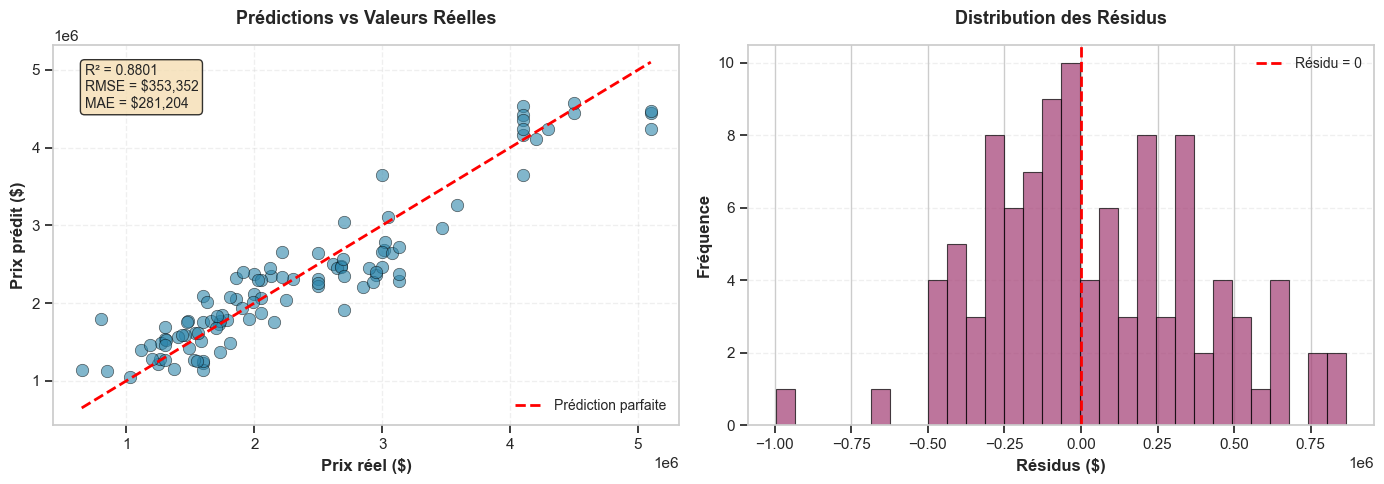


ANALYSE DES RÉSIDUS
Moyenne des résidus    : $45,181.27
Écart-type des résidus : $352,148.30
Résidu min             : $-994,792.72
Résidu max             : $864,255.74
Résidu médian          : $-9,259.11


In [17]:
# Visualisation des prédictions vs valeurs réelles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, y_pred, alpha=0.6, s=80, edgecolors='black', linewidth=0.5, c='#2E86AB')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Prédiction parfaite')
ax1.set_xlabel('Prix réel ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Prix prédit ($)', fontsize=12, fontweight='bold')
ax1.set_title('Prédictions vs Valeurs Réelles', fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Ajout du R² sur le graphique
textstr = f'R² = {r2:.4f}\nRMSE = ${rmse_:,.0f}\nMAE = ${mae:,.0f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Subplot 2 : Distribution des résidus
ax2 = axes[1]
residuals = y_test - y_pred
ax2.hist(residuals, bins=30, alpha=0.7, color='#A23B72', edgecolor='black', linewidth=0.8)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
ax2.set_xlabel('Résidus ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax2.set_title('Distribution des Résidus', fontsize=13, fontweight='bold', pad=15)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# Statistiques sur les résidus
print("\n" + "="*70)
print("ANALYSE DES RÉSIDUS")
print("="*70)
print(f"Moyenne des résidus    : ${residuals.mean():,.2f}")
print(f"Écart-type des résidus : ${residuals.std():,.2f}")
print(f"Résidu min             : ${residuals.min():,.2f}")
print(f"Résidu max             : ${residuals.max():,.2f}")
print(f"Résidu médian          : ${residuals.median():,.2f}")
print("="*70)

## Courbes d’apprentissage : diagnostic biais/variance

/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e+11, tolerance: 3.526e+09
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e+12, tolerance: 8.636e+09
  model = cd_fast.enet_coordinate_descent(
/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-p

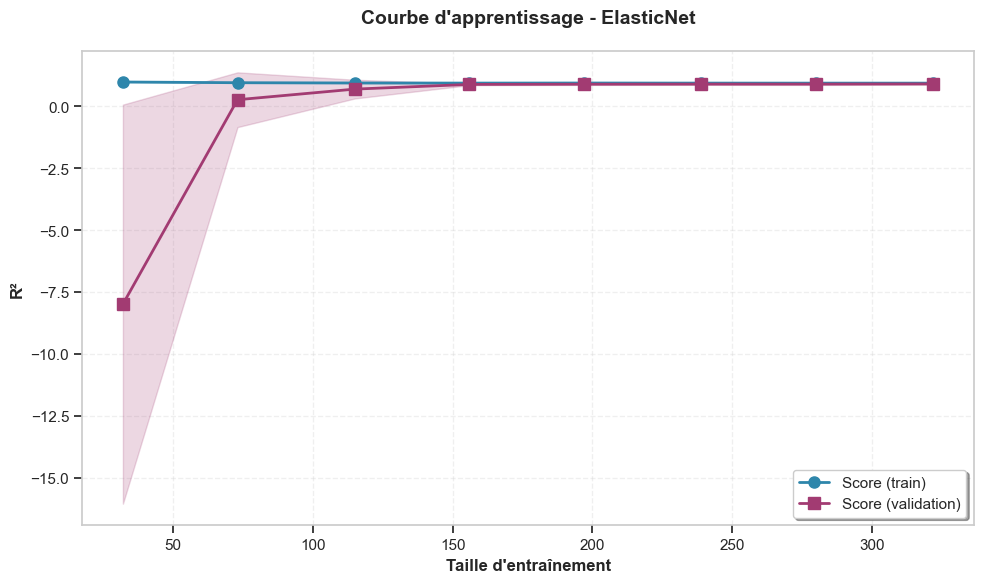


DIAGNOSTIC BIAIS/VARIANCE
Bon équilibre biais/variance (gap = 0.032)
   -> R² train : 0.938
   -> R² val   : 0.906


In [18]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)

train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
val_mean, val_std     = val_scores.mean(axis=1), val_scores.std(axis=1)

# Amélioration visuelle de la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, marker="o", linewidth=2, markersize=8, label="Score (train)", color="#2E86AB")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="#2E86AB")
plt.plot(train_sizes, val_mean, marker="s", linewidth=2, markersize=8, label="Score (validation)", color="#A23B72")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2, color="#A23B72")

plt.xlabel("Taille d'entraînement", fontsize=12, fontweight='bold')
plt.ylabel("R²", fontsize=12, fontweight='bold')
plt.title(f"Courbe d'apprentissage - {best_name}", fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Interprétation automatique
print("\n" + "="*70)
print("DIAGNOSTIC BIAIS/VARIANCE")
print("="*70)
gap = train_mean[-1] - val_mean[-1]
if gap > 0.1:
    print(f"Surapprentissage détecté (gap = {gap:.3f})")
    print("   -> Le modèle performe mieux sur train que sur validation")
    print("   -> Considérer : régularisation plus forte, plus de données")
elif val_mean[-1] < 0.7:
    print(f"Sous-apprentissage détecté (R² val = {val_mean[-1]:.3f})")
    print("   -> Le modèle ne capture pas assez de complexité")
    print("   -> Considérer : features supplémentaires, modèles plus complexes")
else:
    print(f"Bon équilibre biais/variance (gap = {gap:.3f})")
    print(f"   -> R² train : {train_mean[-1]:.3f}")
    print(f"   -> R² val   : {val_mean[-1]:.3f}")
print("="*70)

## Analyse de l'importance des variables

Calcul de l'importance par permutation...


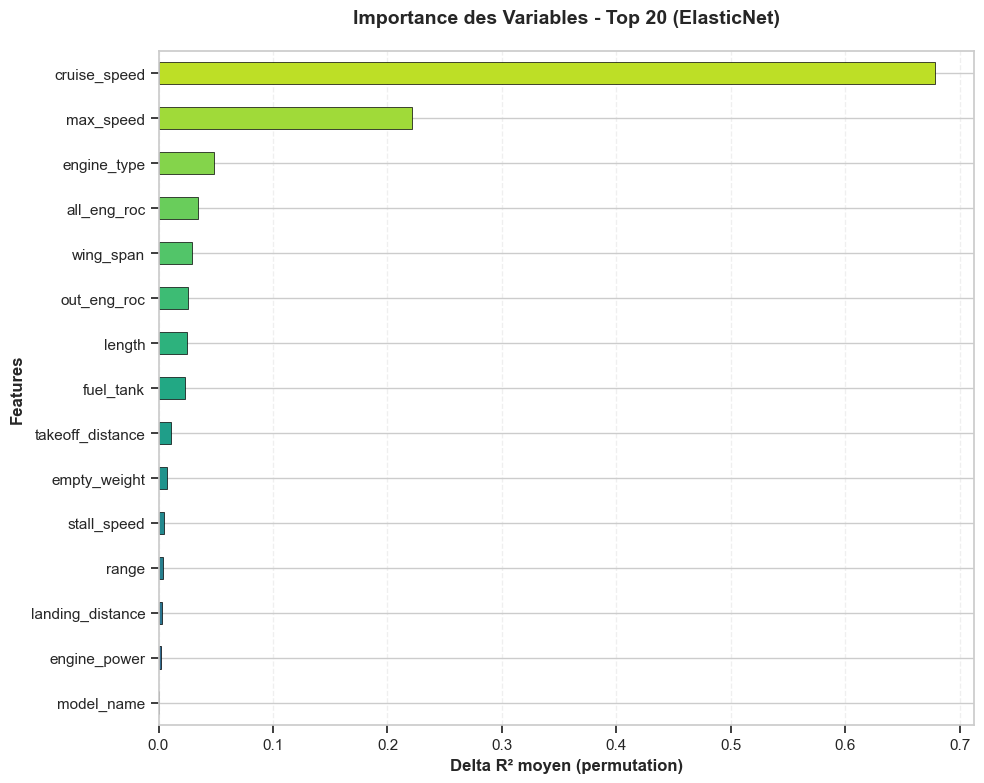


TOP 10 DES FEATURES LES PLUS IMPORTANTES


,Feature,Importance,Importance (%)
1,cruise_speed,0.6783,60.65%
2,max_speed,0.2212,19.78%
3,engine_type,0.0484,4.33%
4,all_eng_roc,0.0341,3.05%
5,wing_span,0.0293,2.62%
6,out_eng_roc,0.0256,2.29%
7,length,0.0247,2.21%
8,fuel_tank,0.0232,2.08%
9,takeoff_distance,0.0106,0.95%
10,empty_weight,0.0075,0.67%


In [19]:
from sklearn.inspection import permutation_importance

print("Calcul de l'importance par permutation...")
result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=20, random_state=42, n_jobs=-1, scoring="r2"
)

# Utilisation des noms de features d'entrée
feature_names = X_test.columns.tolist()

# Création du DataFrame d'importance
importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
topk = importances.head(20)

# Visualisation 
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(topk)))
topk[::-1].plot(kind="barh", ax=ax, color=colors, edgecolor='black', linewidth=0.5)

ax.set_title(f"Importance des Variables - Top 20 ({best_name})", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Delta R² moyen (permutation)", fontsize=12, fontweight='bold')
ax.set_ylabel("Features", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Affichage du top 10 en tableau
print("\n" + "="*70)
print("TOP 10 DES FEATURES LES PLUS IMPORTANTES")
print("="*70)
top10_df = pd.DataFrame({
    'Feature': importances.head(10).index,
    'Importance': importances.head(10).values,
    'Importance (%)': (importances.head(10).values / importances.sum() * 100)
}).reset_index(drop=True)
top10_df.index = top10_df.index + 1  # Commencer à 1
display(top10_df.style.format({
    'Importance': '{:.4f}',
    'Importance (%)': '{:.2f}%'
}).background_gradient(subset=['Importance'], cmap='YlOrRd'))
print("="*70)